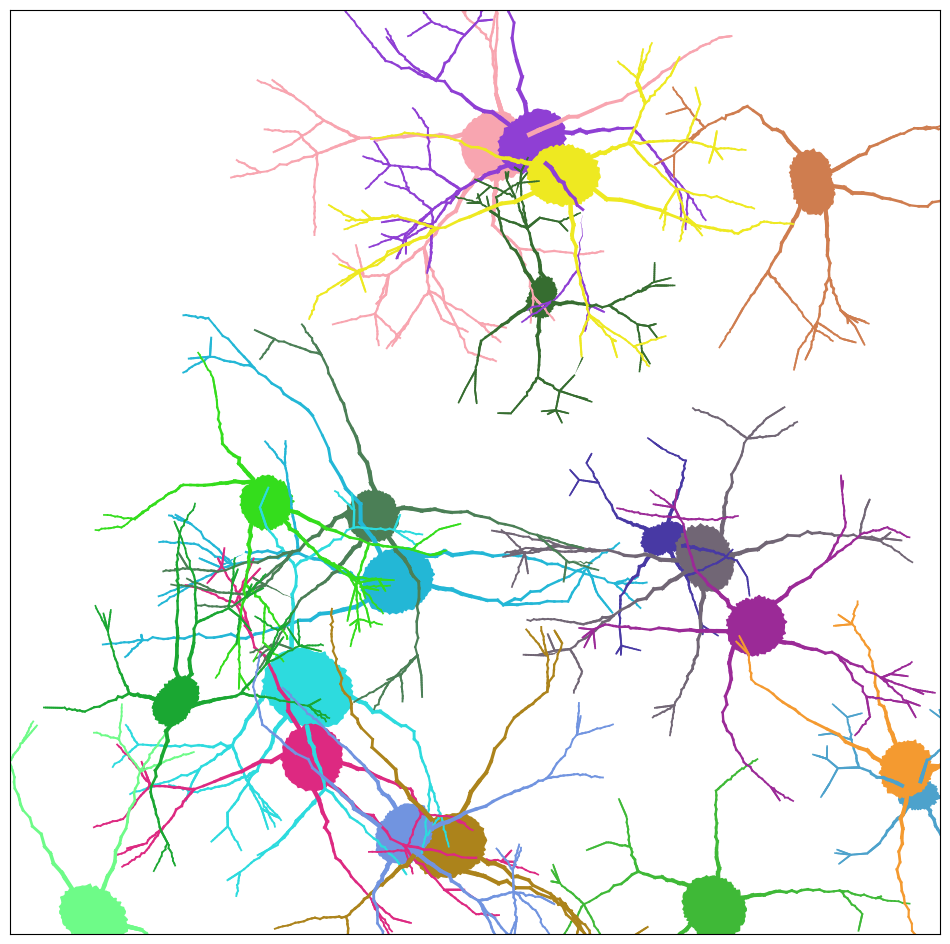

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Neuron:
    def __init__(self, position, depth, mean_soma_radius, std_soma_radius, D, branch_angle, mean_branches, weave_type=None, randomness=0.0, 
                 curviness=None, curviness_magnitude=1.0, num_primary_branches=4):
        
        self.position = position
        self.depth = depth
        
        self.soma_radius = max(np.random.normal(mean_soma_radius, std_soma_radius), 0)  # Ensure non-negative radius
        self.total_length = self._scale_total_length()
        self.initial_thickness = self._scale_initial_thickness()
        
        self.D = D
        self.branch_angle = branch_angle
        self.mean_branches = mean_branches
        self.weave_type = weave_type
        self.randomness = randomness
        self.curviness = curviness
        self.curviness_magnitude = curviness_magnitude
        self.num_primary_branches = num_primary_branches
        self.branch_lengths = self._generate_branch_lengths()
        self.branches_list = []
        
        # Generate soma shape once and store
        self.x_soma, self.y_soma = self._generate_soma()

    def _scale_total_length(self):
        base_length = 40  # A base length for the dendrites
        length_variation_factor = 5  # A factor to scale variability
        total_length = base_length + (self.soma_radius * length_variation_factor) * np.random.uniform(0.8, 1.2)
        return max(total_length, 0)

    def _scale_initial_thickness(self):
        base_thickness = 1  # A base thickness
        thickness_factor = 0.001  # A factor to scale thickness with soma size and total length
        initial_thickness = base_thickness + thickness_factor * (self.soma_radius + self.total_length)
        return max(initial_thickness, 1)  # Ensure minimum thickness

    def _generate_branch_lengths(self):
        r = self.mean_branches ** (-1 / self.D)
        branch_lengths = np.zeros(self.depth)
        normalization_factor = self.total_length / sum(r**i for i in range(self.depth))
        
        for i in range(self.depth):
            branch_lengths[i] = normalization_factor * r**i
        
        return branch_lengths
    
    def _generate_soma(self):
        # Generate an irregular, but less spiky, shape to represent the soma
        theta = np.linspace(0, 2 * np.pi, 100)
        sine_variation = np.random.uniform(0, 15) * np.sin(2 * theta)  # Smooth sinusoidal variation
        gaussian_variation = np.random.normal(0, 2, len(theta))  # Small random Gaussian noise
        ellipse_ratio = np.random.uniform(0.8, 1.2)  # Control the degree of elongation

        elongation_angle = np.random.uniform(0, 2 * np.pi)  # Random angle for elongation direction
        x_soma = (self.soma_radius + gaussian_variation + sine_variation) * (np.cos(theta) * np.cos(elongation_angle) - np.sin(theta) * np.sin(elongation_angle) * ellipse_ratio) + self.position[0]
        y_soma = (self.soma_radius + gaussian_variation + sine_variation) * (np.sin(theta) * np.cos(elongation_angle) + np.cos(theta) * np.sin(elongation_angle) * ellipse_ratio) + self.position[1]
        
        return x_soma, y_soma

    def _calculate_thickness(self, distance_from_start, segment_length):
        thickness_at_start = self.initial_thickness * (distance_from_start / self.total_length) ** (-1 / self.D)
        thickness_at_end = self.initial_thickness * ((distance_from_start + segment_length) / self.total_length) ** (-1 / self.D)
        return thickness_at_start, thickness_at_end

    def _generate_dendrite_start_points(self):
        start_points = []
        num_soma_points = len(self.x_soma)
        base_indices = np.linspace(0, num_soma_points - 1, self.num_primary_branches, endpoint=False).astype(int)

        # Introduce randomness to the indices
        random_offsets = np.random.randint(-num_soma_points // (100 // self.num_primary_branches // 1.5), 
                                                                (100 // self.num_primary_branches // 1.5) + 1, 
                                                                size=self.num_primary_branches)  # Random offsets
        
        random_indices = (base_indices + random_offsets) % num_soma_points  # Ensure indices stay within valid range

        # Use these randomized indices to select points on the soma perimeter
        for index in random_indices:
            start_points.append((self.x_soma[index], self.y_soma[index]))

        return start_points

    def _generate_branches(self):
        start_points = self._generate_dendrite_start_points()
        for start_point in start_points:
            self._grow_branch(start_point[0], start_point[1], np.arctan2(start_point[1] - self.position[1], start_point[0] - self.position[0]), self.depth)
    
    def _grow_branch(self, x, y, angle, depth):
        if depth == 0:
            return
        
        length = self.branch_lengths[len(self.branch_lengths) - depth]
        if self.weave_type == 'Gauss':
            length *= 1 + np.random.normal(0, self.randomness)
            angle += np.random.normal(0, self.randomness)
        elif self.weave_type == 'Uniform':
            length *= 1 + np.random.uniform(-self.randomness, self.randomness)
            angle += np.random.uniform(-self.randomness, self.randomness)
        
        end_x = x + length * np.cos(angle)
        end_y = y + length * np.sin(angle)
        
        current_length = sum(self.branch_lengths[:len(self.branch_lengths) - depth + 1])
        thickness_start, thickness_end = self._calculate_thickness(current_length, length)

        self.branches_list.append([(x, y), (end_x, end_y), length, thickness_start, thickness_end, depth])
        
        branches = int(np.clip(np.round(np.random.normal(self.mean_branches, 1)), 1, None))

        for i in range(branches):
            new_angle = angle + self.branch_angle * (i - (branches - 1) / 2)
            if self.weave_type == 'Gauss':
                new_angle += np.random.normal(0, self.randomness)
            elif self.weave_type == 'Uniform':
                new_angle += np.random.uniform(-self.randomness, self.randomness)
            self._grow_branch(end_x, end_y, new_angle, depth - 1)

    def _draw_weaving_line(self, x1, y1, x2, y2, length, thickness_start, thickness_end, color):
        num_points = int(self.curviness_magnitude * 10)
        xs = np.linspace(x1, x2, num_points)
        ys = np.linspace(y1, y2, num_points)
        thicknesses = np.linspace(thickness_start, thickness_end, num_points)
        
        if self.curviness == 'Gauss':
            perturb_xs = xs + (length // 50) * np.random.normal(0, 1, num_points)
            perturb_ys = ys + (length // 50) * np.random.normal(0, 1, num_points)
        elif self.curviness == 'Uniform':
            perturb_xs = xs + (length // 50) * np.random.uniform(-1, 1, num_points)
            perturb_ys = ys + (length // 50) * np.random.uniform(-1, 1, num_points)
        else:
            perturb_xs = xs
            perturb_ys = ys
            
        perturb_xs[0], perturb_ys[0] = x1, y1
        perturb_xs[-1], perturb_ys[-1] = x2, y2
        
        for i in range(num_points - 1):
            plt.plot(perturb_xs[i:i+2], perturb_ys[i:i+2], color=color, linewidth=thicknesses[i])

    def _draw(self, color):
        # Draw the soma
        plt.fill(self.x_soma, self.y_soma, color=color)
        
        # Draw the branches
        for branch in self.branches_list:
            self._draw_weaving_line(branch[0][0], branch[0][1], branch[1][0], branch[1][1], branch[2], branch[3], branch[4], color=color)

    def _connect_branches(self, other_neuron=None, connection_threshold=5.0):
        if other_neuron is None:
            for i, branch1 in enumerate(self.branches_list):
                for j, branch2 in enumerate(self.branches_list):
                    if i != j:
                        dist = np.linalg.norm(np.array(branch1[1]) - np.array(branch2[1]))
                        if dist < connection_threshold:
                            if branch1[2] < branch2[2]:
                                branch1[3] = 0
                            else:
                                branch2[3] = 0
        else:
            for branch1 in self.branches_list:
                for branch2 in other_neuron.branches_list:
                    dist = np.linalg.norm(np.array(branch1[1]) - np.array(branch2[1]))
                    if dist < connection_threshold:
                        if branch1[2] < branch2[2]:
                            branch1[3] = 0
                        else:
                            branch2[3] = 0

class Network:
    def __init__(self, width, height, num_neurons, neuron_params):
        self.width = width
        self.height = height
        self.num_neurons = num_neurons
        self.neuron_params = neuron_params
        self.neurons = []

    def _seed_neurons(self):
        for _ in range(self.num_neurons):
            position = (np.random.uniform(0, self.width), np.random.uniform(0, self.height))
            neuron = Neuron(position, **self.neuron_params)
            neuron._generate_branches()
            neuron._connect_branches()
            self.neurons.append(neuron)

    def _generate_network(self):
        self._seed_neurons()

    def _simulate_connections(self):
        for i, neuron in enumerate(self.neurons):
            for j in range(i + 1, len(self.neurons)):
                neuron._connect_branches(self.neurons[j])

    def draw(self):
        plt.figure(figsize=(12, 12))
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])        
    
        # Draw each neuron with a different color
        for neuron in self.neurons:
            color = np.random.rand(3,)  # Random color for each neuron
            neuron._draw(color=color)
            
        plt.axis('equal')
        plt.xlim(0, self.width)
        plt.ylim(0, self.height)
        plt.show()
        
# Parameters
network_width = 2048
network_height = 2048
num_neurons = 20

# Neuron-specific parameters with Gaussian distribution
neuron_params = {
    'depth': 4,
    'mean_soma_radius': 60,
    'std_soma_radius': 15,
    'D': 1.2,
    'branch_angle': np.pi / 4,
    'mean_branches': 1.5,
    'weave_type': 'Gauss',
    'randomness': 0.3,
    'curviness': 'Gauss',
    'curviness_magnitude': 1,
    'num_primary_branches': 5
}

# Create and generate the network
network = Network(network_width, network_height, num_neurons, neuron_params)
network._generate_network()

# Simulate connections between neurons
network._simulate_connections()

# Draw the network
network.draw()
